In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Sat Jan 27 01:05:30 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   51C    P0    78W / 300W |   8299MiB / 80994MiB |     26%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-5_hardquantize/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

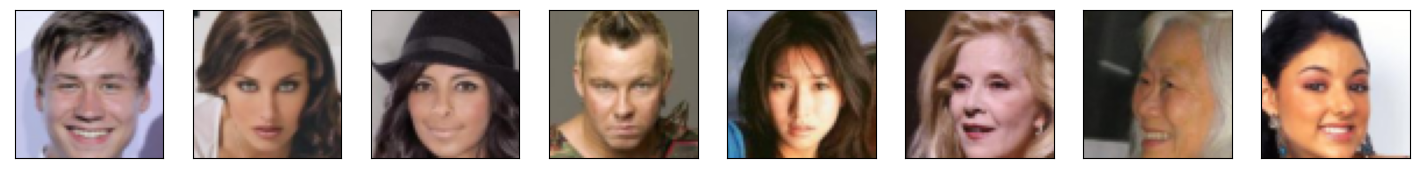

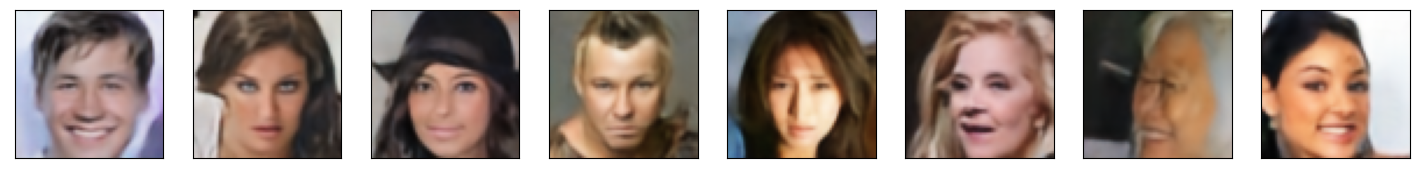

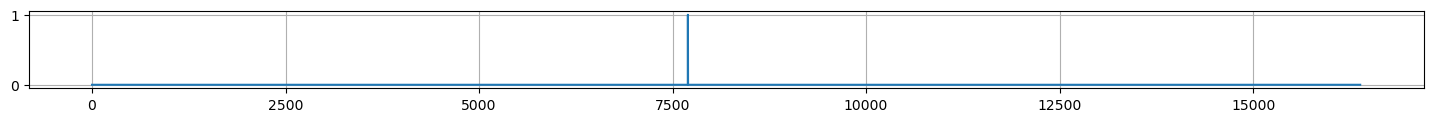

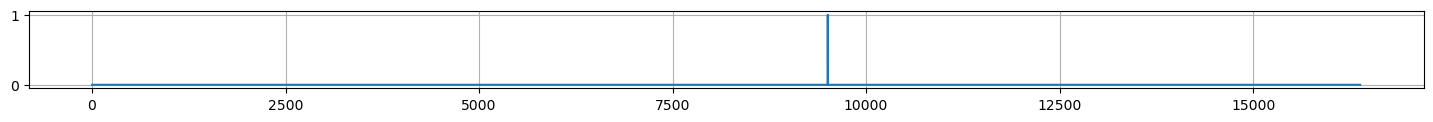

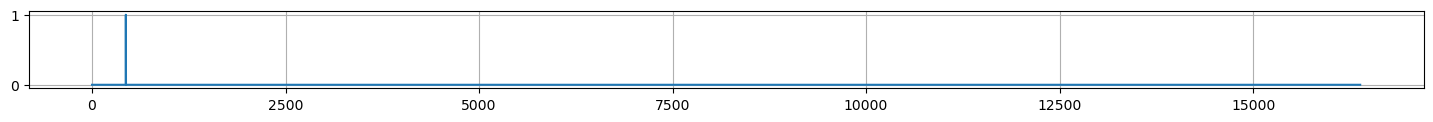

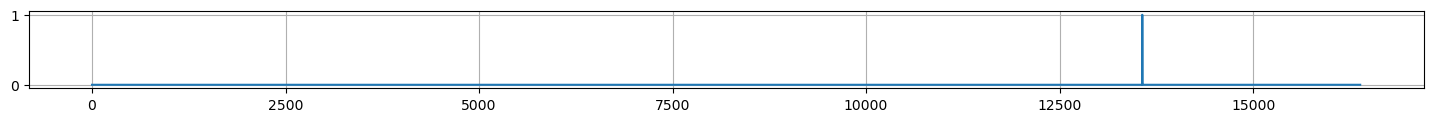

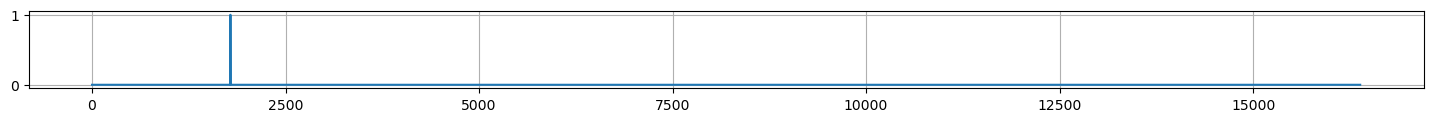

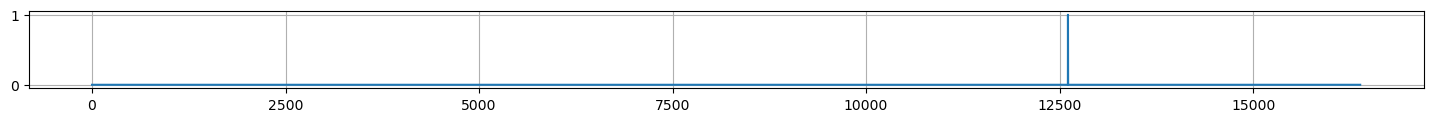

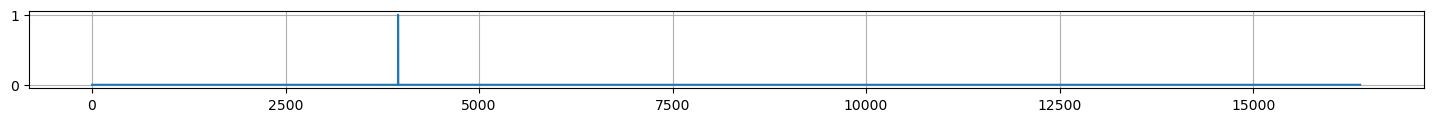

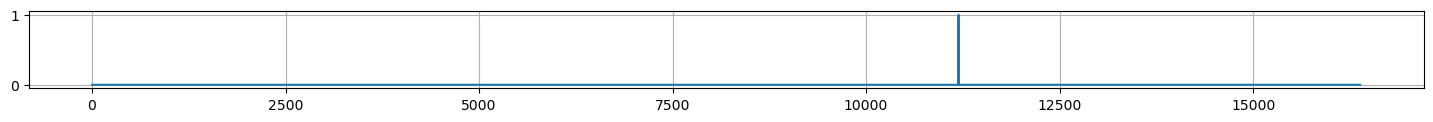

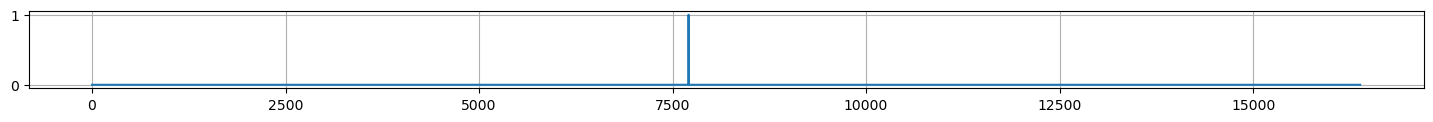

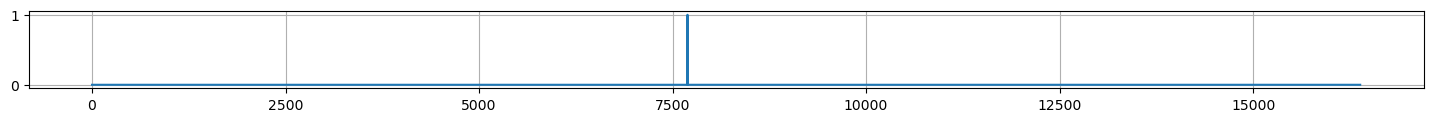

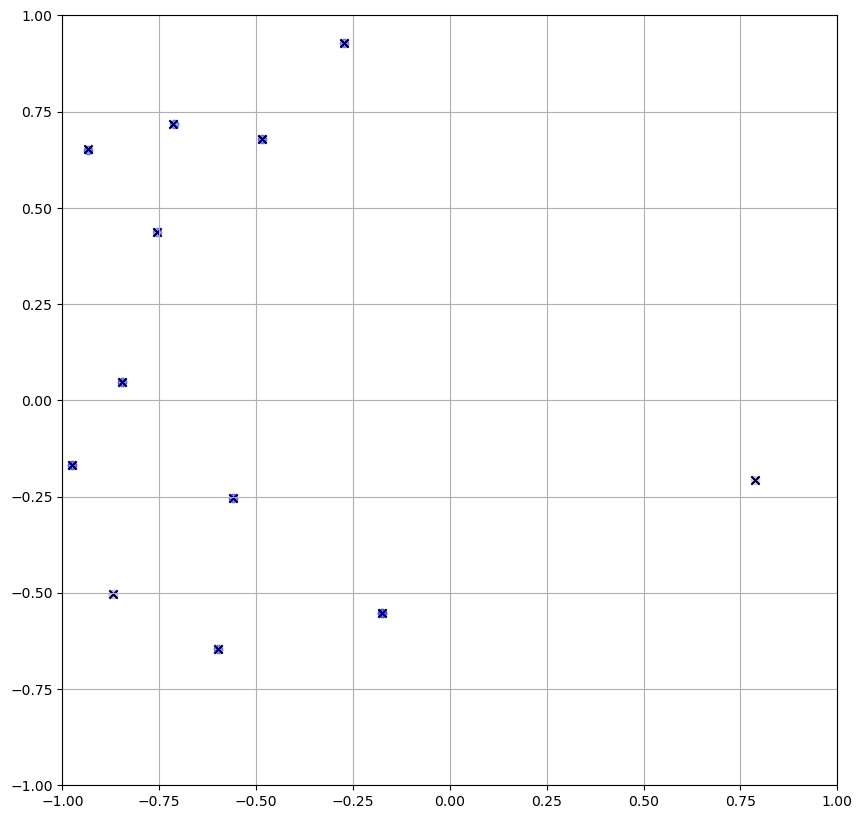

381001
lse_loss -107.67229461669922
commit_loss 0.2541749179363251
recon_loss 0.0015862019499763846
381002
lse_loss -108.6534652709961
commit_loss 0.2543095648288727
recon_loss 0.0015170220285654068
381003
lse_loss -103.09066772460938
commit_loss 0.25414544343948364
recon_loss 0.001399233820848167
381004
lse_loss -109.79812622070312
commit_loss 0.25042423605918884
recon_loss 0.0013753033708781004
381005
lse_loss -108.3011703491211
commit_loss 0.25531017780303955
recon_loss 0.0014334069564938545
381006
lse_loss -108.07997131347656
commit_loss 0.25203150510787964
recon_loss 0.0014520667027682066
381007
lse_loss -109.10517120361328
commit_loss 0.25334227085113525
recon_loss 0.001430532312951982
381008
lse_loss -106.2417221069336
commit_loss 0.25392842292785645
recon_loss 0.001401402405463159
381009
lse_loss -107.2872314453125
commit_loss 0.2512704133987427
recon_loss 0.0014498864766210318
381010
lse_loss -104.33277893066406
commit_loss 0.25756025314331055
recon_loss 0.0014691483229398727


lse_loss -106.83151245117188
commit_loss 0.2575891613960266
recon_loss 0.0014699478633701801
381084
lse_loss -105.99049377441406
commit_loss 0.25638866424560547
recon_loss 0.0014358807820826769
381085
lse_loss -108.26821899414062
commit_loss 0.2511723041534424
recon_loss 0.00161513383500278
381086
lse_loss -105.58477783203125
commit_loss 0.2554376721382141
recon_loss 0.0014316918095573783
381087
lse_loss -105.12163543701172
commit_loss 0.25787001848220825
recon_loss 0.001459938008338213
381088
lse_loss -108.11791229248047
commit_loss 0.2516639232635498
recon_loss 0.001453965320251882
381089
lse_loss -107.95488739013672
commit_loss 0.2559030055999756
recon_loss 0.0015405755257233977
381090
lse_loss -104.74280548095703
commit_loss 0.2595437467098236
recon_loss 0.0014239484444260597
381091
lse_loss -105.34153747558594
commit_loss 0.2524954080581665
recon_loss 0.001493798103183508
381092
lse_loss -108.33033752441406
commit_loss 0.25547558069229126
recon_loss 0.001483839936554432
381093
lse

381166
lse_loss -107.2394027709961
commit_loss 0.2544475793838501
recon_loss 0.0014196204720064998
381167
lse_loss -102.30509185791016
commit_loss 0.2586015462875366
recon_loss 0.0015214085578918457
381168
lse_loss -107.29671478271484
commit_loss 0.25818532705307007
recon_loss 0.00149005395360291
381169
lse_loss -107.49441528320312
commit_loss 0.2567383050918579
recon_loss 0.0015030915383249521
381170
lse_loss -105.41232299804688
commit_loss 0.2547552287578583
recon_loss 0.0015198939945548773
381171
lse_loss -106.47755432128906
commit_loss 0.25168120861053467
recon_loss 0.0015522215981036425
381172
lse_loss -106.63481903076172
commit_loss 0.25526097416877747
recon_loss 0.001524101011455059
381173
lse_loss -110.71443939208984
commit_loss 0.25274351239204407
recon_loss 0.0014748238027095795
381174
lse_loss -108.53299713134766
commit_loss 0.25150051712989807
recon_loss 0.0013609586749225855
381175
lse_loss -107.85816955566406
commit_loss 0.24950158596038818
recon_loss 0.001406806521117687

lse_loss -103.2728042602539
commit_loss 0.25302472710609436
recon_loss 0.0013919221237301826
381249
lse_loss -110.31810760498047
commit_loss 0.25415316224098206
recon_loss 0.0015768533339723945
381250
lse_loss -107.30895233154297
commit_loss 0.2543650269508362
recon_loss 0.001491631381213665
381251
lse_loss -107.7408676147461
commit_loss 0.25034767389297485
recon_loss 0.0015217207837849855
381252
lse_loss -102.83970642089844
commit_loss 0.25635552406311035
recon_loss 0.0014000334776937962
381253
lse_loss -109.59508514404297
commit_loss 0.25124603509902954
recon_loss 0.0014058230444788933
381254
lse_loss -104.31814575195312
commit_loss 0.25620850920677185
recon_loss 0.00155375967733562
381255
lse_loss -107.0562973022461
commit_loss 0.2557251453399658
recon_loss 0.001419362612068653
381256
lse_loss -108.20891571044922
commit_loss 0.2531396150588989
recon_loss 0.0014618204440921545
381257
lse_loss -107.38687896728516
commit_loss 0.25484251976013184
recon_loss 0.0014042494585737586
381258


381331
lse_loss -101.03771209716797
commit_loss 0.25720635056495667
recon_loss 0.0013658828102052212
381332
lse_loss -107.92719268798828
commit_loss 0.2512306571006775
recon_loss 0.0014599477872252464
381333
lse_loss -105.9844970703125
commit_loss 0.2612094283103943
recon_loss 0.0015178662724792957
381334
lse_loss -107.1038818359375
commit_loss 0.2526111304759979
recon_loss 0.001492893323302269
381335
lse_loss -104.35128021240234
commit_loss 0.2534502148628235
recon_loss 0.0014994621742516756
381336
lse_loss -105.85362243652344
commit_loss 0.25595569610595703
recon_loss 0.0014036268694326282
381337
lse_loss -107.19111633300781
commit_loss 0.25519731640815735
recon_loss 0.001507813110947609
381338
lse_loss -105.96380615234375
commit_loss 0.2502756714820862
recon_loss 0.0015316910576075315
381339
lse_loss -107.76371002197266
commit_loss 0.2512738108634949
recon_loss 0.0015435245586559176
381340
lse_loss -108.59493255615234
commit_loss 0.24965015053749084
recon_loss 0.001444001216441393
3

lse_loss -110.20760345458984
commit_loss 0.2504812479019165
recon_loss 0.0014969634357839823
381414
lse_loss -106.675537109375
commit_loss 0.25746864080429077
recon_loss 0.0015206411480903625
381415
lse_loss -109.24658966064453
commit_loss 0.25155746936798096
recon_loss 0.001482880674302578
381416
lse_loss -106.96598052978516
commit_loss 0.25308215618133545
recon_loss 0.0015430597122758627
381417
lse_loss -106.39661407470703
commit_loss 0.2504383325576782
recon_loss 0.0015869727358222008
381418
lse_loss -110.0030288696289
commit_loss 0.2507167458534241
recon_loss 0.0013982955133542418
381419
lse_loss -109.16133117675781
commit_loss 0.2502807080745697
recon_loss 0.0015453285304829478
381420
lse_loss -107.85588836669922
commit_loss 0.25461360812187195
recon_loss 0.0014545379672199488
381421
lse_loss -105.85950469970703
commit_loss 0.2534523606300354
recon_loss 0.0013853264972567558
381422
lse_loss -109.08919525146484
commit_loss 0.2499108612537384
recon_loss 0.001465808367356658
381423
l

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp=0)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-5
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [12]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


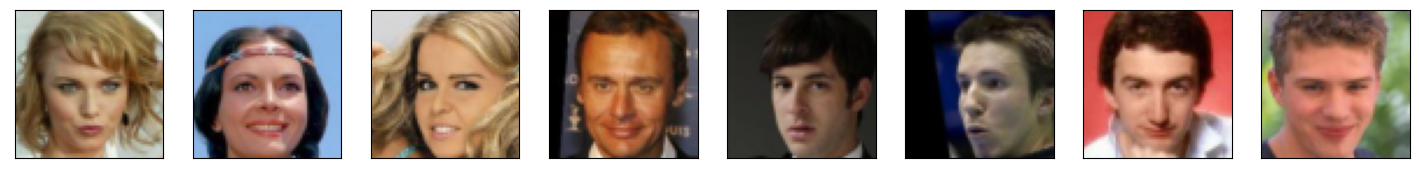

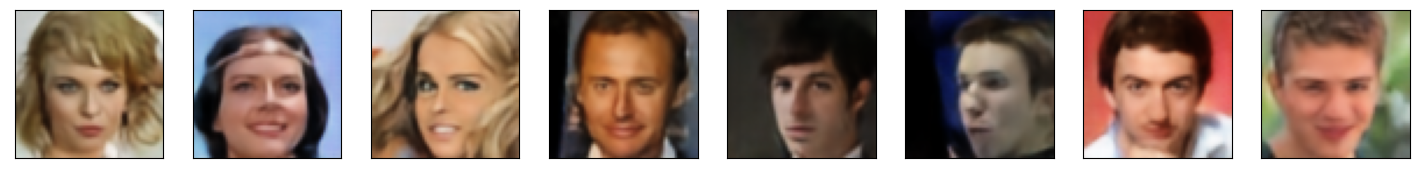

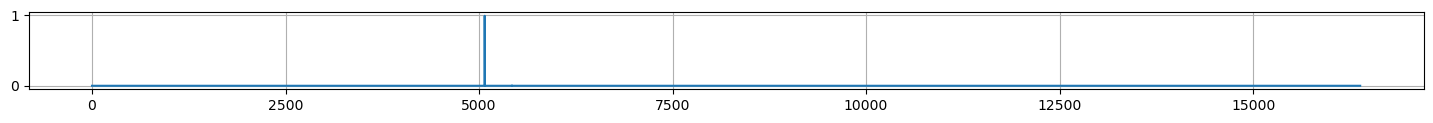

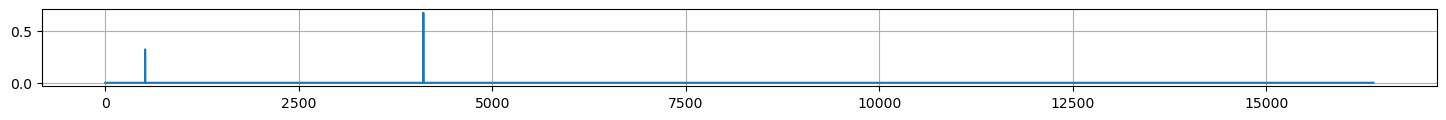

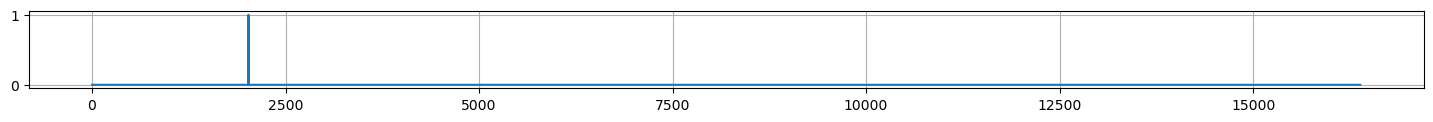

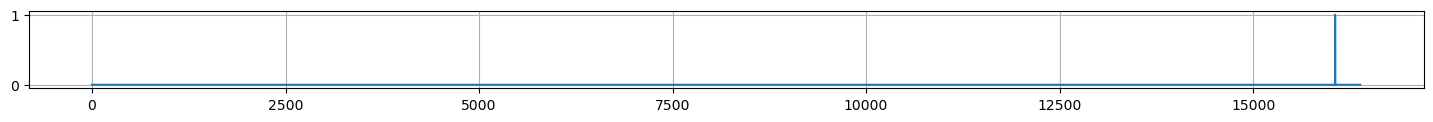

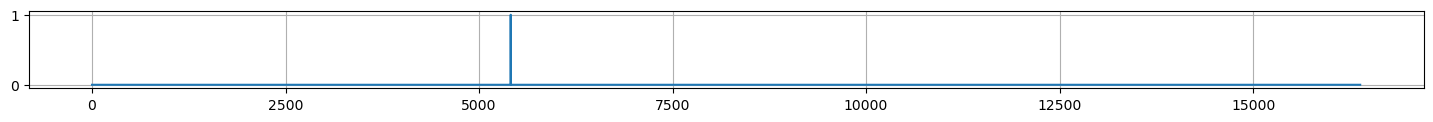

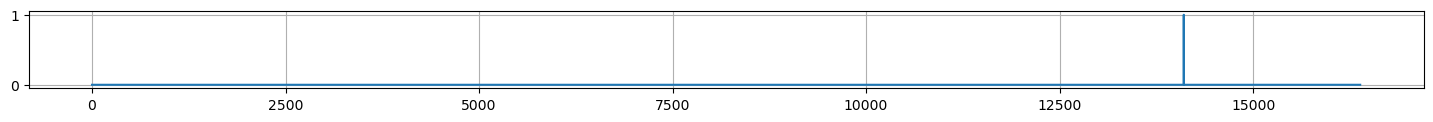

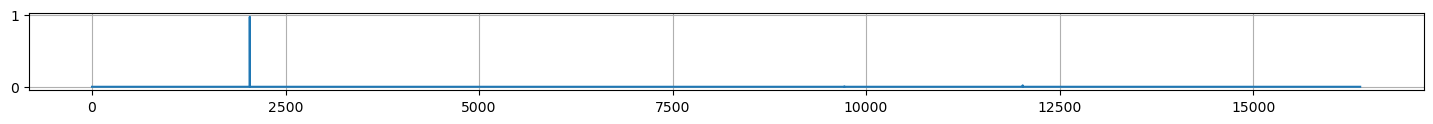

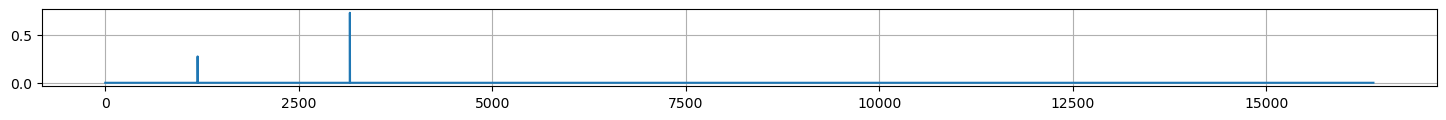

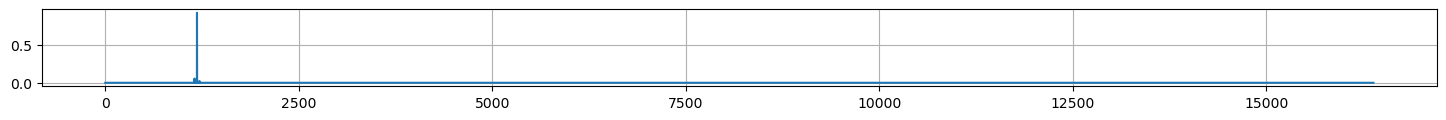

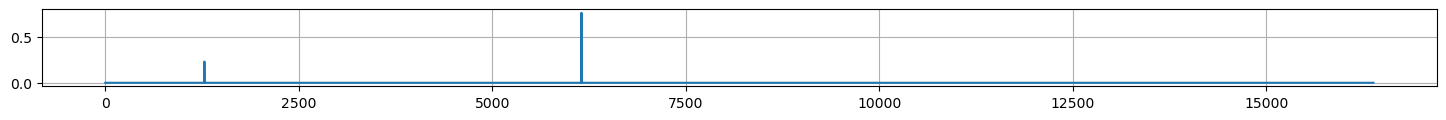

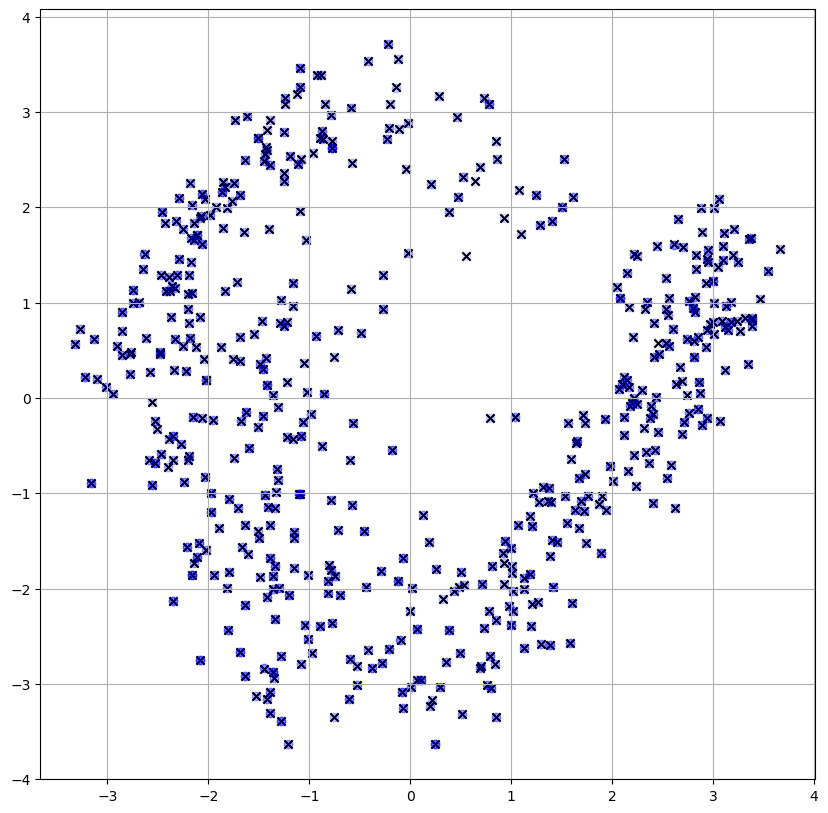

In [14]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 